In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [5]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [6]:
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [7]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [8]:
df = df.drop(columns=["deck"])

In [9]:
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [10]:
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

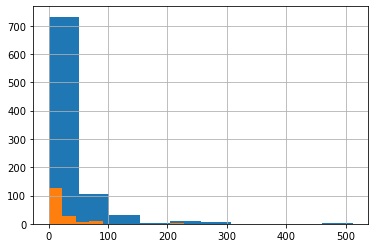

In [11]:
df.fare.hist(), no_age_info.fare.hist();

In [12]:
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print()
    print()

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64


pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64


sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64


sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64


parch
Population:
0    0.760943
1    0.132435
2    0.089787
3    0.005612
5    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No age
0    0.887006
2    0.067797
1    0.045198
Name: parch, dtype: float64


embark_town
Population:
Southampton    0.724409
Cherbou

In [13]:
df.age = df.age.fillna(value=df.age.median())

In [14]:
# Time to encode the encodeable!
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

# Drop the original columns we encoded
df = df.drop(columns=["sex", "embark_town"])

# Stitch the df and the dummy_df together again
df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [15]:
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)

In [16]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [17]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [18]:
# Make the model
tree1 = DecisionTreeClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
tree1 = tree1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = tree1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.820433,0.760000,0.799197,0.790217,0.797255
recall,0.863192,0.696335,0.799197,0.779764,0.799197
f1-score,0.841270,0.726776,0.799197,0.784023,0.797358
support,307.000000,191.000000,0.799197,498.000000,498.000000


In [19]:
for i in range(2, 11):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.831858    0.842767  0.835341    0.837313      0.836042
recall       0.918567    0.701571  0.835341    0.810069      0.835341
f1-score     

In [20]:
metrics = []

for i in range(2, 25):
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    tree = tree.fit(X_train, y_train)

    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.799065,0.054348
4,6,0.865462,0.789720,0.075742
5,7,0.883534,0.780374,0.103160
6,8,0.899598,0.789720,0.109879
7,9,0.917671,0.799065,0.118605
8,10,0.937751,0.785047,0.152704
9,11,0.955823,0.813084,0.142739


# Decision Tree Exercises

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

In [24]:
df = acquire.get_titanic_data()
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [25]:
df = df.set_index("passenger_id")
df = df.drop(columns=["class", "embarked"])

In [26]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
deck           688
embark_town      2
alone            0
dtype: int64

In [27]:
df = df.drop(columns=["deck"])

In [28]:
df.embark_town = df.embark_town.fillna(value=df.embark_town.mode())

In [29]:
no_age_info = df[df.age.isna()]
no_age_info.alone.value_counts()

1    133
0     44
Name: alone, dtype: int64

In [30]:
for column in df.drop(columns=["age", "fare"]).columns:
    print(column)
    print("Population:")
    print(df[column].value_counts(normalize=True))
    print("No age")
    print(no_age_info[column].value_counts(normalize=True))
    print('----------------------------------')

survived
Population:
0    0.616162
1    0.383838
Name: survived, dtype: float64
No age
0    0.706215
1    0.293785
Name: survived, dtype: float64
----------------------------------
pclass
Population:
3    0.551066
1    0.242424
2    0.206510
Name: pclass, dtype: float64
No age
3    0.768362
1    0.169492
2    0.062147
Name: pclass, dtype: float64
----------------------------------
sex
Population:
male      0.647587
female    0.352413
Name: sex, dtype: float64
No age
male      0.700565
female    0.299435
Name: sex, dtype: float64
----------------------------------
sibsp
Population:
0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: sibsp, dtype: float64
No age
0    0.774011
1    0.146893
8    0.039548
3    0.022599
2    0.016949
Name: sibsp, dtype: float64
----------------------------------
parch
Population:
0    0.760943
1    0.132435
2    0.089787
3    0.005612
5    0.005612
4    0.004489
6    0.001122
Name: parch, dtype: float64
No

In [31]:
df.age = df.age.fillna(value=df.age.median())

In [32]:
dummy_df = pd.get_dummies(df[['sex','embark_town']], dummy_na=False, drop_first=[True, True])

df = df.drop(columns=["sex", "embark_town"])

df = pd.concat([df, dummy_df], axis=1)
df.head()

,survived,pclass,age,sibsp,parch,fare,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
passenger_id,,,,,,,,,,
0,0,3,22.0,1,0,7.2500,0,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,1,0,1


In [33]:
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.survived)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [34]:
baseline = y_train.mode()

matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.62


In [36]:
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

tree1 = forest1.fit(X_train, y_train)


y_predictions = forest1.predict(X_train)

report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.773481,0.801471,0.781124,0.787476,0.784216
recall,0.912052,0.570681,0.781124,0.741366,0.781124
f1-score,0.837070,0.666667,0.781124,0.751868,0.771715
support,307.000000,191.000000,0.781124,498.000000,498.000000


In [39]:
for i in range(2, 11):
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    forest = forest.fit(X_train, y_train)

    y_predictions = forest.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print('-------------------------------------------------------------------------------')

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.815029    0.835526  0.821285    0.825278      0.822890
recall       0.918567    0.664921  0.821285    0.791744      0.821285
f1-score     0.863706    0.740525  0.821285    0.802115      0.816462
support    307.000000  191.000000  0.821285  498.000000    498.000000
-------------------------------------------------------------------------------
Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.836257    0.865385  0.845382    0.850821      0.847429
recall       0.931596    0.706806  0.845382    0.819201      0.845382
f1-score     0.881356    0.778098  0.845382    0.829727      0.841753
support    307.000000  191.000000  0.845382  498.000000    498.000000
-------------------------------------------------------------------------------
Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted

In [40]:
metrics = []

for i in range(2, 25):
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    forest = forest.fit(X_train, y_train)

    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

In [41]:
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.821285,0.771028,0.050257
1,3,0.845382,0.794393,0.050989
2,4,0.855422,0.799065,0.056356
3,5,0.865462,0.803738,0.061724
4,6,0.891566,0.813084,0.078482
5,7,0.927711,0.822430,0.105281
6,8,0.945783,0.808411,0.137372
7,9,0.957831,0.803738,0.154093
8,10,0.969880,0.813084,0.156795
9,11,0.977912,0.808411,0.169500


In [43]:
threshold = 0.10

models = []
metrics = []

for i in range(2, 25):
    forest = RandomForestClassifier(max_depth=i, min_samples_leaf=1, random_state=123)

    forest = forest.fit(X_train, y_train)

    in_sample_accuracy = forest.score(X_train, y_train)   
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    difference = in_sample_accuracy - out_of_sample_accuracy
    
    if difference > threshold:
        break
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "difference": difference
    }
    
    metrics.append(output)
    
    models.append(forest)
    
df = pd.DataFrame(metrics)
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.821285,0.771028,0.050257
1,3,0.845382,0.794393,0.050989
2,4,0.855422,0.799065,0.056356
3,5,0.865462,0.803738,0.061724
4,6,0.891566,0.813084,0.078482


In [44]:
metrics = []
max_depth = 20

for i in range(2, max_depth):
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    forest = forest.fit(X_train, y_train)

    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.925703,0.822430,0.103273
1,3,17,0.901606,0.817757,0.083849
2,4,16,0.887550,0.817757,0.069793
3,5,15,0.877510,0.780374,0.097136
4,6,14,0.871486,0.799065,0.072421
5,7,13,0.869478,0.789720,0.079758
6,8,12,0.865462,0.794393,0.071069
7,9,11,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,9,0.849398,0.785047,0.064351


In [46]:
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.821285,0.771028,0.050257
1,3,3,0.845382,0.785047,0.060335
2,4,4,0.847390,0.794393,0.052997
3,5,5,0.859438,0.799065,0.060372
4,6,6,0.861446,0.799065,0.062380
5,7,7,0.863454,0.789720,0.073734
6,8,8,0.863454,0.789720,0.073734
7,9,9,0.855422,0.794393,0.061029
8,10,10,0.857430,0.785047,0.072383
9,11,11,0.849398,0.785047,0.064351


In [48]:
metrics = []
max_depth = 50

for i in range(2, max_depth):
    depth = 10
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    forest = forest.fit(X_train, y_train)

    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,10,0.921687,0.822430,0.099257
1,3,10,0.899598,0.808411,0.091187
2,4,10,0.887550,0.813084,0.074466
3,5,10,0.877510,0.794393,0.083118
4,6,10,0.871486,0.799065,0.072421
5,7,10,0.869478,0.789720,0.079758
6,8,10,0.867470,0.794393,0.073077
7,9,10,0.857430,0.794393,0.063037
8,10,10,0.857430,0.785047,0.072383
9,11,10,0.849398,0.785047,0.064351
